# Постановка задачи

В рамках текущего задания необходимо реализовать упрощенную модель градиентного бустинга, придерживаясь ряда условий, описанных в ТЗ,  в частности это долен быть градиентный бустинг над регрессионными деревьями для случая квадратичной функции потерь.  
Проверку нужно произвести используя классический бостонский датасет из библиотеки sklearn, а полученные результаты соизмерить с классической линейной регрессией


## Подготовка данных и  окружения

In [0]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = load_boston()
X = df.data
y = df.target
size = len(df.target)
print(size, size == len(df.target))

506 True


Разобъем данные на выборки для обучения и тестирования, в сооотношении 75/25 %, с сохранением порядка

In [3]:
X_train, X_test, y_train, y_test = (
    X[:int(0.75*size)], X[int(0.75*size):],
    y[:int(0.75*size)], y[int(0.75*size):])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(379, 13) (379,)
(127, 13) (127,)


Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.  
Воспользуйтемся формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь L - квадрат отклонения ответа композиции a(x) от правильного ответа y на данном x

$$\sum_{i=0}^{l} \mathbb{L}(y_i, a_{N-1}(x_i) + \xi_i)  =  \sum_{i=0}^{l} (y_i - (a_{N-1}(x_i) + \xi_i))^2 \to \min_{\xi}$$  

$$\xi_i = 2(y_i - a_{N-1}(x_i).$$

## Реализация алгоритма
Определим  функцию, которая будет вычислять прогноз построенной  композиции деревьев на выборке `X` и функцию расчета градиента (согласно условию  - 2 не берем в расчет)

In [0]:
def gbm_predict(X):
  '''
  base_algorithms_list - список с базовыми алгоритмами
  coefficients_list - список с коэффициентами перед алгоритмами
  '''
  return [sum([
      coeff*algo.predict([x])[0] for algo, coeff
      in zip(base_algorithms_list, coefficients_list)
  ]) for x in X]


def get_grad():
  return [y - a for a, y in zip(gbm_predict(X_train), y_train)]

В качестве базового алгоритма для градиентного бустинга будет использовано регресионное дерево решений из библиотеки sklearn. Воспроизводимость ответов на платформе coursera предписывает установить для него параметры `max_depth=5` и `random_state=42`  
В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод)  

Определим ф-цию, обучающую 50 базовых алгоритмов.  

Попробуем при этом для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

In [0]:
base_algorithms_list, coefficients_list = [], []

def gboost_fit(coef, minimize_coef=False):
  for i in range(50):
    coef = coef/(1.0 + i) if minimize_coef else coef
    base_model = DecisionTreeRegressor(max_depth=5, random_state=42)
    base_model.fit(X_train, get_grad())
    base_algorithms_list.append(base_model)
    coefficients_list.append(coef)

gboost_fit(0.9)  

In [6]:
def get_RMSE():
  MSE = mean_squared_error(
      y_test,
      gbm_predict(X_test)
  )
  return MSE**0.5


get_RMSE()

5.455565103009402

А теперь попробуем уменьшать вес перед каждым алгоритмом с каждой следующей итерацией

In [0]:
base_algorithms_list, coefficients_list = [], [] # Переопределим
gboost_fit(0.9, True)

In [8]:
get_RMSE()

4.409771514361549

## Оценка путем сравнения с другими регресионными моделями  
Сравним реализованный алгоритм с тем, что предлагает библиотека XGBoost 

In [9]:
xbg = XGBRegressor(n_estimators=50, max_depth=5)
xbg.fit(X_train, y_train)
xbg_pred = xbg.predict(X_test)
mean_squared_error(y_test, xbg_pred)**0.5

[08:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


4.923855118818414

Получили соизмеримую величину ошибки, отчасти из-за некоторой синтетичности в реализации.



In [10]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_model_pred = linear_model.predict(X_test)
mean_squared_error(y_test, linear_model_pred)**0.5

8.254979753549401

По причине того, что модель проста и никак не адаптирована - получили требуемое по заданию и ожидаемое ухудшение качества

## Анализ влияния параметров градиентного бустинга на качество

Для чистоты эксперемента сравнение будем производить на широко используемом алгоритме XGBRegressor, вместо лабораторного

[08:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Text(0, 0.5, 'error')

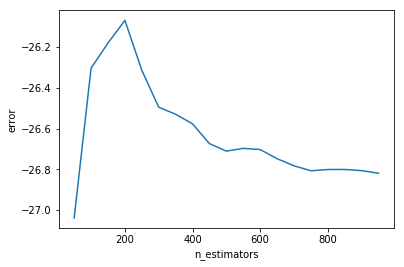

In [11]:
trees, errors = np.arange(50, 1000, 50), []
for tree in trees:
  errors.append(
      cross_val_score(XGBRegressor(n_estimators=tree),
                      X,
                      y,
                      scoring='neg_mean_squared_error').mean()
    )
plt.plot(trees, errors)
plt.xlabel("n_estimators")
plt.ylabel("error")

[08:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

Text(0, 0.5, 'error')

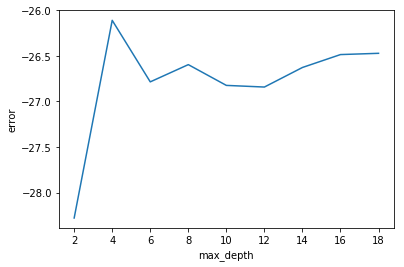

In [12]:
depth, errors = np.arange(2, 20, 2), []
for d in depth:
  errors.append(
      cross_val_score(XGBRegressor(max_depth=d),
                      X,
                      y,
                      scoring='neg_mean_squared_error').mean()
    )
plt.plot(depth, errors)
plt.xlabel("max_depth")
plt.ylabel("error")